# Atividade Cap 1 - FarmTech na era da cloud computing - FASE 5

### Entrega 1:

Você e o seu grupo estão na FarmTech Solutions prestando serviços de IA para uma fazenda de médio porte (200 hectares ou aproximadamente 210 campos de futebol oficiais) que produz várias culturas. Seu time precisa analisar uma base de dados com informações de condições de solo e temperatura, relacionadas com o tipo de produto agrícola dessa fazenda. Você deverá prever o rendimento de safra (conforme visto no capítulo 13 - Modelagem de Dados com Regressão Supervisionada, da Fase 4) e explorar a tendência de produtividade (visto no capítulo 10 - Machine Learning Sem Supervisão: Uma Jornada pela Descoberta de Dados, da Fase 5).

Base de dados: a base está foi fornecida no portal FIAP ON, disponível no arquivo “crop_yield.csv"

Metas da Entrega 1:

Baseado no dataset apresentado, sua atividade consiste em:

Fazer uma análise exploratória na base para se familiarizar com os dados;
Encontrar tendências para os rendimentos das plantações, por meio de clusterizações, e identificar se existem cenários discrepantes (outliers);
Fazer cinco modelos preditivos (cada um com um algoritmo diferente, conforme visto no capítulo “Modelagem de Dados com Regressão Supervisionada”) que, dadas as condições, prevejam qual será o rendimento da safra. Esta parte da tarefa inclui seguir as boas práticas dos projetos de Machine Learning, assim como avaliar o modelo com métricas pertinentes ao problema.

## Iniciando
Importando bibliotecas, algoritmos

Visualizando alguns dados

In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

from xgboost import XGBRegressor

In [74]:
# Configurações iniciais
plt.style.use('ggplot')
sns.set_palette('viridis')

# 1. Carregar os dados
df = pd.read_csv('crop_yield.csv')

# 2. Análise Exploratória (EDA)
print("="*50)
print("Análise Exploratória")
print("="*50)

# Informações básicas
print("\nPrimeiras linhas do dataset:")
print(df.head())
print("\nInformações do dataset:")
print(df.info())
print("\nEstatísticas descritivas:")
print(df.describe())

# Análise de valores faltantes
print("\nValores faltantes por coluna:")
print(df.isnull().sum())

Análise Exploratória

Primeiras linhas do dataset:
           Crop  Precipitation (mm day-1)  \
0  Cocoa, beans                   2248.92   
1  Cocoa, beans                   1938.42   
2  Cocoa, beans                   2301.54   
3  Cocoa, beans                   2592.35   
4  Cocoa, beans                   2344.72   

   Specific Humidity at 2 Meters (g/kg)  Relative Humidity at 2 Meters (%)  \
0                                 17.72                              83.40   
1                                 17.54                              82.11   
2                                 17.81                              82.79   
3                                 17.61                              85.07   
4                                 17.61                              84.12   

   Temperature at 2 Meters (C)  Yield  
0                        26.01  11560  
1                        26.11  11253  
2                        26.24   9456  
3                        25.56   9321  
4        

Visualizando...

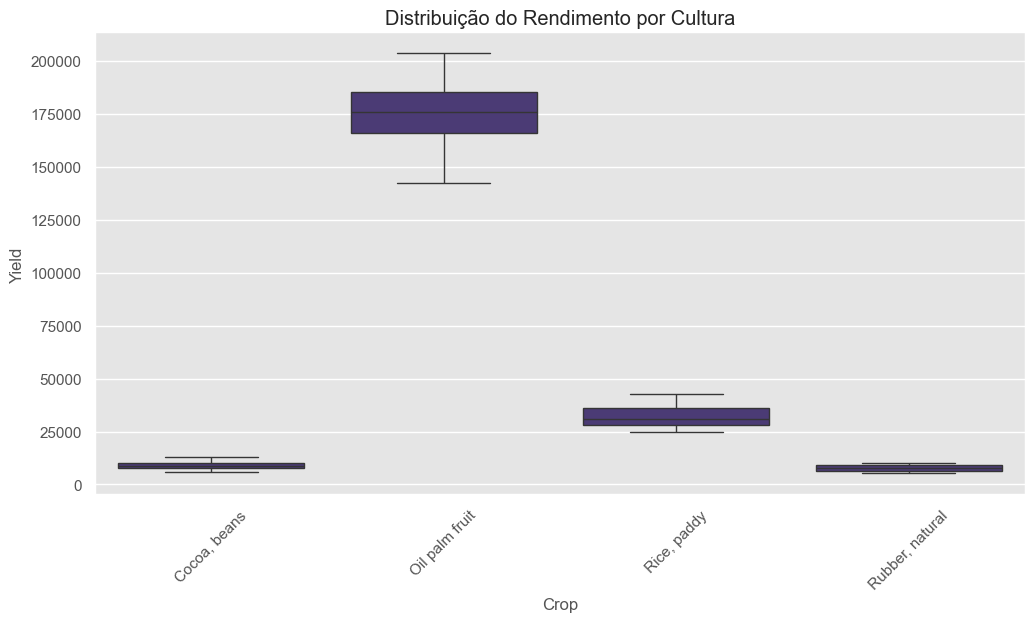

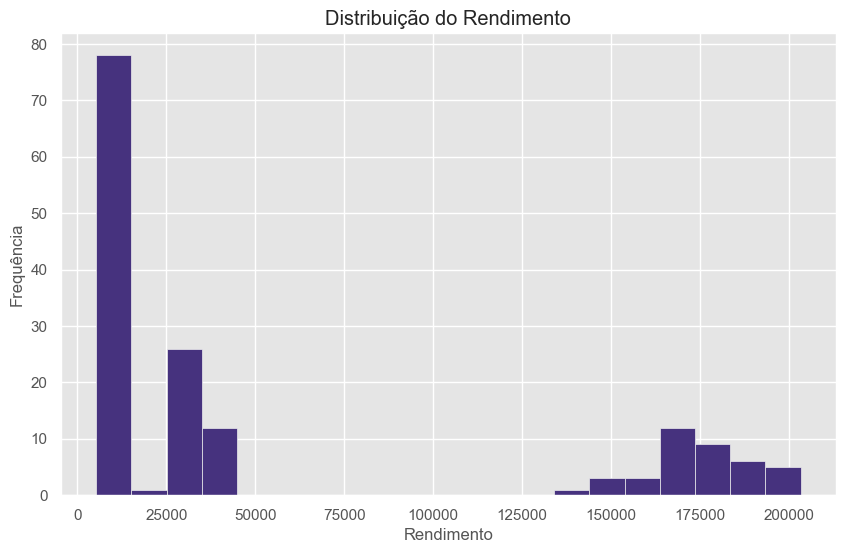

In [75]:
# Visualizações
plt.figure(figsize=(12, 6))
sns.boxplot(x='Crop', y='Yield', data=df)
plt.title('Distribuição do Rendimento por Cultura')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(10, 6))
df['Yield'].hist(bins=20)
plt.title('Distribuição do Rendimento')
plt.xlabel('Rendimento')
plt.ylabel('Frequência')
plt.show()

In [76]:
# Pré-processamento
# Separar features e target
X = df.drop('Yield', axis=1)
y = df['Yield']

# Definir transformações
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['Precipitation (mm day-1)', 'Specific Humidity at 2 Meters (g/kg)',
                                   'Relative Humidity at 2 Meters (%)', 'Temperature at 2 Meters (C)']),
        ('cat', OneHotEncoder(), ['Crop'])
    ])

# Aplicar transformações
X_processed = preprocessor.fit_transform(X)



# Clusterização - Machine Learning não Supervisionado
print("\n" + "="*50)
print("Análise de Clusterização")
print("="*50)

# K-Means com Elbow Method
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_processed)
    inertia.append(kmeans.inertia_)



Análise de Clusterização


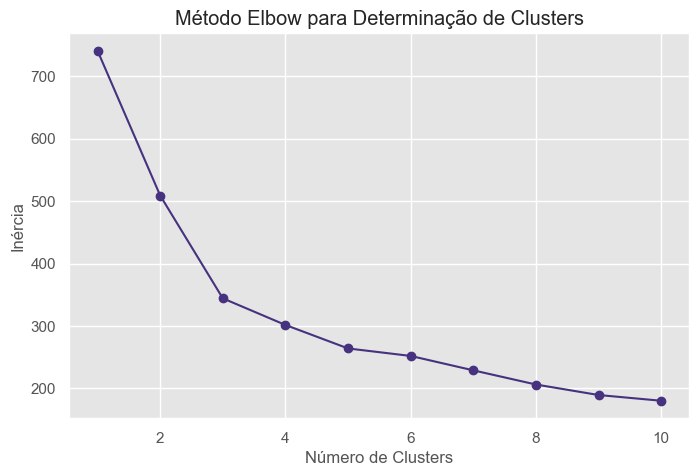

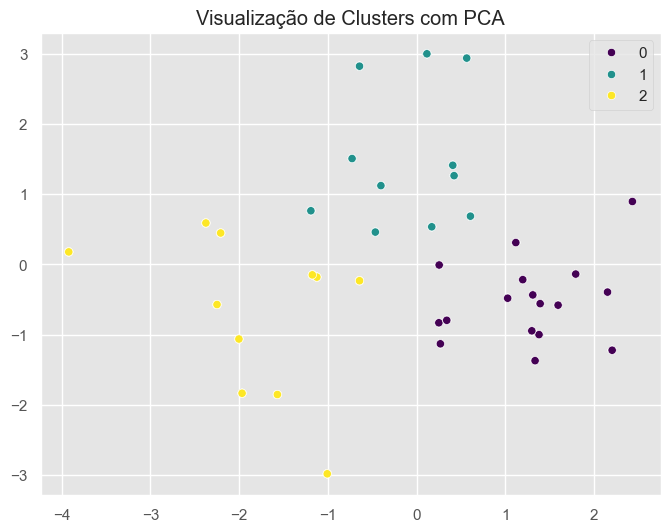

In [77]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Método Elbow para Determinação de Clusters')
plt.xlabel('Número de Clusters')
plt.ylabel('Inércia')
plt.show()

# Clusterização final com K=3
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_processed)

# Visualização com PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_processed)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=clusters, palette='viridis')
plt.title('Visualização de Clusters com PCA')
plt.show()

In [78]:
# Outliers com DBSCAN
dbscan = DBSCAN(eps=3, min_samples=5)
outliers = dbscan.fit_predict(X_processed)
print(f"\nNúmero de outliers detectados: {sum(outliers == -1)}")


Número de outliers detectados: 0


## Modelagem Preditiva

In [79]:
# Regressão Supervisionada

# Divisão treino-teste
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)



param_grid = {
    'n_estimators': [100, 200, 300],    
    'max_depth': [10, 20, None],         
    'min_samples_split': [2, 5, 10],     
    'max_features': ['sqrt', 'log2']     
}


rf = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)
melhor_modelo = grid_search.best_estimator_





# Dicionário de modelos
models = {
    'Regressão Linear': LinearRegression(),
    'Árvore de Decisão': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(random_state=42),
    'SVR': SVR(),
    'XGBoost': XGBRegressor(random_state=42)
}


# Avaliação dos modelos
results = []
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    # Métricas
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    # Validação cruzada
    cv_scores = cross_val_score(model, X_processed, y, cv=5, scoring='r2')
    
    results.append({
        'Modelo': name,
        'RMSE': rmse,
        'MAE': mae,
        'R²': r2,
        'R² CV Médio': np.mean(cv_scores)
    })

In [80]:
# Resultados
results_df = pd.DataFrame(results)
print("\nDesempenho dos Modelos:")
print(results_df.sort_values(by='R²', ascending=False))

# 6. Feature Importance (Exemplo para Random Forest)
feature_names = (preprocessor.named_transformers_['cat'].get_feature_names_out().tolist() +
                 ['Precipitação', 'Umidade Específica', 'Umidade Relativa', 'Temperatura'])

rf = RandomForestRegressor().fit(X_processed, y)
importance = pd.Series(rf.feature_importances_, index=feature_names).sort_values(ascending=False)


Desempenho dos Modelos:
              Modelo          RMSE           MAE        R²  R² CV Médio
0   Regressão Linear   4394.165819   3132.796384  0.995022    -2.354374
2      Random Forest   4747.895480   2729.503438  0.994189     0.099360
1  Árvore de Decisão   5640.314021   3440.687500  0.991799    -0.409999
4            XGBoost   6753.509014   3987.932373  0.988242    -1.253999
3                SVR  71310.524786  38970.978089 -0.310964   -88.016208
